In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import SklearnClassifier
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

/root/anaconda3/envs/exp2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, Tuple, Any, TYPE_CHECKING

import numpy as np
from scipy.ndimage import zoom
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import (
    compute_success,
    get_labels_np_array,
    check_and_transform_label_format,
)

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_TYPE

logger = logging.getLogger(__name__)


class ZooAttack(EvasionAttack):
 

    attack_params = EvasionAttack.attack_params + [
        "confidence",
        "targeted",
        "learning_rate",
        "max_iter",
        "binary_search_steps",
        "initial_const",
        "abort_early",
        "use_resize",
        "use_importance",
        "nb_parallel",
        "batch_size",
        "variable_h",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, ClassifierMixin)

    def __init__(
        self,
        classifier: "CLASSIFIER_TYPE",
        confidence: float = 0.0,
        targeted: bool = False,
        learning_rate: float = 1e-2,
        max_iter: int = 10,
        binary_search_steps: int = 1,
        initial_const: float = 1e-3,
        abort_early: bool = True,
        use_resize: bool = True,
        use_importance: bool = True,
        nb_parallel: int = 128,
        batch_size: int = 1,
        variable_h: float = 1e-4,
        verbose: bool = True,
    ):
        
        super().__init__(estimator=classifier)

        if len(classifier.input_shape) == 1:
            self.input_is_feature_vector = True
            if batch_size != 1:
                raise ValueError(
                    "The current implementation of Zeroth-Order Optimisation attack only supports "
                    "`batch_size=1` with feature vectors as input."
                )
        else:
            self.input_is_feature_vector = False

        self.confidence = confidence
        self._targeted = targeted
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.binary_search_steps = binary_search_steps
        self.initial_const = initial_const
        self.abort_early = abort_early
        self.use_resize = use_resize
        self.use_importance = use_importance
        self.nb_parallel = nb_parallel
        self.batch_size = batch_size
        self.variable_h = variable_h
        self.verbose = verbose
        self._check_params()

        
        self._init_size = 32
        if self.abort_early:
            self._early_stop_iters = self.max_iter // 10 if self.max_iter >= 10 else self.max_iter

        
        if self.input_is_feature_vector:
            self.use_resize = False
            self.use_importance = False
            logger.info( 
                "Disable resizing and importance sampling because feature vector input has been detected."
            )

        if self.use_resize:
            if not self.estimator.channels_first:
                dims = (batch_size, self._init_size, self._init_size, self.estimator.input_shape[-1])
            else:  
                dims = (batch_size, self.estimator.input_shape[0], self._init_size, self._init_size)
            self._current_noise = np.zeros(dims, dtype=ART_NUMPY_DTYPE)
        else:
            self._current_noise = np.zeros((batch_size,) + self.estimator.input_shape, dtype=ART_NUMPY_DTYPE)
        self._sample_prob = np.ones(self._current_noise.size, dtype=ART_NUMPY_DTYPE) / self._current_noise.size

        self.adam_mean: Optional[np.ndarray] = None
        self.adam_var: Optional[np.ndarray] = None
        self.adam_epochs: Optional[np.ndarray] = None

    def _loss(
        self, x: np.ndarray, x_adv: np.ndarray, target: np.ndarray, c_weight: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        l2dist = np.sum(np.square(x - x_adv).reshape(x_adv.shape[0], -1), axis=1)
        ratios = [1.0] + [
            int(new_size) / int(old_size) for new_size, old_size in zip(self.estimator.input_shape, x.shape[1:])
        ]
        preds = self.estimator.predict(np.array(zoom(x_adv, zoom=ratios)), batch_size=self.batch_size)
        z_target = np.sum(preds * target, axis=1)
        z_other = np.max(
            preds * (1 - target) + (np.min(preds, axis=1) - 1)[:, np.newaxis] * target,
            axis=1,
        )

        if self.targeted:
            
            loss = np.maximum(z_other - z_target + self.confidence, 0)
        else:
            
            loss = np.maximum(z_target - z_other + self.confidence, 0)

        return preds, l2dist, c_weight * loss + l2dist

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:

        if y is not None:
            y = check_and_transform_label_format(y, nb_classes=self.estimator.nb_classes)

        
        if self.targeted and y is None:  
            raise ValueError("Target labels `y` need to be provided for a targeted attack.")

        
        if y is None:
            y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size))

        if self.estimator.nb_classes == 2 and y.shape[1] == 1:  
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

       
        nb_batches = int(np.ceil(x.shape[0] / float(self.batch_size)))
        x_adv_list = []
        for batch_id in trange(nb_batches, desc="ZOO", disable=not self.verbose):
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            x_batch = x[batch_index_1:batch_index_2]
            y_batch = y[batch_index_1:batch_index_2]
            res = self._generate_batch(x_batch, y_batch)
            x_adv_list.append(res)
        x_adv = np.vstack(x_adv_list)

        
        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            np.clip(x_adv, clip_min, clip_max, out=x_adv)

        
        logger.info(
            "Success rate of ZOO attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, x_adv, self.targeted, batch_size=self.batch_size),
        )

        return x_adv

    def _generate_batch(self, x_batch: np.ndarray, y_batch: np.ndarray) -> np.ndarray:
        
        c_current = self.initial_const * np.ones(x_batch.shape[0])
        c_lower_bound = np.zeros(x_batch.shape[0])
        c_upper_bound = 1e10 * np.ones(x_batch.shape[0])

       
        o_best_dist = np.inf * np.ones(x_batch.shape[0])
        o_best_attack = x_batch.copy()

       
        for bss in range(self.binary_search_steps):
            logger.debug(
                "Binary search step %i out of %i (c_mean==%f)",
                bss,
                self.binary_search_steps,
                np.mean(c_current),
            )

            
            best_dist, best_label, best_attack = self._generate_bss(x_batch, y_batch, c_current)

            
            o_best_attack[best_dist < o_best_dist] = best_attack[best_dist < o_best_dist]
            o_best_dist[best_dist < o_best_dist] = best_dist[best_dist < o_best_dist]

           
            c_current, c_lower_bound, c_upper_bound = self._update_const(
                y_batch, best_label, c_current, c_lower_bound, c_upper_bound
            )

        return o_best_attack

    def _update_const(
        self,
        y_batch: np.ndarray,
        best_label: np.ndarray,
        c_batch: np.ndarray,
        c_lower_bound: np.ndarray,
        c_upper_bound: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        

        comparison = [
            self._compare(best_label[i], np.argmax(y_batch[i])) and best_label[i] != -np.inf
            for i in range(len(c_batch))
        ]
        for i, comp in enumerate(comparison):
            if comp:
                
                c_upper_bound[i] = min(c_upper_bound[i], c_batch[i])
                if c_upper_bound[i] < 1e9:
                    c_batch[i] = (c_lower_bound[i] + c_upper_bound[i]) / 2
            else:
                
                c_lower_bound[i] = max(c_lower_bound[i], c_batch[i])
                c_batch[i] = (c_lower_bound[i] + c_upper_bound[i]) / 2 if c_upper_bound[i] < 1e9 else c_batch[i] * 10

        return c_batch, c_lower_bound, c_upper_bound

    def _compare(self, object1: Any, object2: Any) -> bool:
        
        return object1 == object2 if self.targeted else object1 != object2

    def _generate_bss(
        self, x_batch: np.ndarray, y_batch: np.ndarray, c_batch: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        

        x_orig = x_batch.astype(ART_NUMPY_DTYPE)
        fine_tuning = np.full(x_batch.shape[0], False, dtype=bool)
        prev_loss = 1e6 * np.ones(x_batch.shape[0])
        prev_l2dist = np.zeros(x_batch.shape[0])

       
        if self.use_resize:
            x_orig = self._resize_image(x_orig, self._init_size, self._init_size, True)
            assert (x_orig != 0).any()
            x_adv = x_orig.copy()
        else:
            x_orig = x_batch
            self._reset_adam(np.prod(self.estimator.input_shape).item())
            if x_batch.shape == self._current_noise.shape:
                self._current_noise.fill(0)
            else:
                self._current_noise = np.zeros(x_batch.shape, dtype=ART_NUMPY_DTYPE)
            x_adv = x_orig.copy()

        
        best_dist = np.inf * np.ones(x_adv.shape[0])
        best_label = -np.inf * np.ones(x_adv.shape[0])
        best_attack = np.array([x_adv[i] for i in range(x_adv.shape[0])])

        for iter_ in range(self.max_iter):
            logger.debug("Iteration step %i out of %i", iter_, self.max_iter)

            
            if self.use_resize:
                if iter_ == 2000:
                    x_adv = self._resize_image(x_adv, 64, 64)
                    x_orig = zoom(
                        x_orig,
                        [
                            1,
                            x_adv.shape[1] / x_orig.shape[1],
                            x_adv.shape[2] / x_orig.shape[2],
                            x_adv.shape[3] / x_orig.shape[3],
                        ],
                    )
                elif iter_ == 10000:
                    x_adv = self._resize_image(x_adv, 128, 128)
                    x_orig = zoom(
                        x_orig,
                        [
                            1,
                            x_adv.shape[1] / x_orig.shape[1],
                            x_adv.shape[2] / x_orig.shape[2],
                            x_adv.shape[3] / x_orig.shape[3],
                        ],
                    )

            
            x_adv = self._optimizer(x_adv, y_batch, c_batch)
            preds, l2dist, loss = self._loss(x_orig, x_adv, y_batch, c_batch)

            
            mask_fine_tune = (~fine_tuning) & (loss == l2dist) & (prev_loss != prev_l2dist)
            fine_tuning[mask_fine_tune] = True
            self._reset_adam(self.adam_mean.size, np.repeat(mask_fine_tune, x_adv[0].size)) 
            prev_l2dist = l2dist

            
            if self.abort_early and iter_ % self._early_stop_iters == 0:
                if (loss > 0.9999 * prev_loss).all():
                    break
                prev_loss = loss

            
            labels_batch = np.argmax(y_batch, axis=1)
            for i, (dist, pred) in enumerate(zip(l2dist, np.argmax(preds, axis=1))):
                if dist < best_dist[i] and self._compare(pred, labels_batch[i]):
                    best_dist[i] = dist
                    best_attack[i] = x_adv[i]
                    best_label[i] = pred

        best_attack = np.array(best_attack)
        if self.use_resize:
            if not self.estimator.channels_first:
                best_attack = zoom(
                    best_attack,
                    [
                        1,
                        int(x_batch.shape[1]) / best_attack.shape[1],
                        int(x_batch.shape[2]) / best_attack.shape[2],
                        1,
                    ],
                )
            else:
                best_attack = zoom(
                    best_attack,
                    [
                        1,
                        1,
                        int(x_batch.shape[2]) / best_attack.shape[2],
                        int(x_batch.shape[2]) / best_attack.shape[3],
                    ],
                )

        return best_dist, best_label, best_attack

    def _optimizer(self, x: np.ndarray, targets: np.ndarray, c_batch: np.ndarray) -> np.ndarray:
       
        coord_batch = np.repeat(self._current_noise, 2 * self.nb_parallel, axis=0)
        coord_batch = coord_batch.reshape(2 * self.nb_parallel * self._current_noise.shape[0], -1)

       
        if self.use_importance and np.unique(self._sample_prob).size != 1:
            indices = (
                np.random.choice(
                    coord_batch.shape[-1] * x.shape[0],
                    self.nb_parallel * self._current_noise.shape[0],
                    replace=False,
                    p=self._sample_prob.flatten(),
                )
                % coord_batch.shape[-1]
            )
        else:
            try:
                indices = (
                    np.random.choice(
                        coord_batch.shape[-1] * x.shape[0],
                        self.nb_parallel * self._current_noise.shape[0],
                        replace=False,
                    )
                    % coord_batch.shape[-1]
                )
            except ValueError as error:  
                if "Cannot take a larger sample than population when 'replace=False'" in str(error):
                    raise ValueError(
                        "Too many samples are requested for the random indices. Try to reduce the number of parallel"
                        "coordinate updates `nb_parallel`."
                    ) from error

                raise error

        
        for i in range(self.nb_parallel * self._current_noise.shape[0]):
            coord_batch[2 * i, indices[i]] += self.variable_h
            coord_batch[2 * i + 1, indices[i]] -= self.variable_h

        
        expanded_x = np.repeat(x, 2 * self.nb_parallel, axis=0).reshape((-1,) + x.shape[1:])
        expanded_targets = np.repeat(targets, 2 * self.nb_parallel, axis=0).reshape((-1,) + targets.shape[1:])
        expanded_c = np.repeat(c_batch, 2 * self.nb_parallel)
        _, _, loss = self._loss(
            expanded_x,
            expanded_x + coord_batch.reshape(expanded_x.shape),
            expanded_targets,
            expanded_c,
        )
        if self.adam_mean is not None and self.adam_var is not None and self.adam_epochs is not None:
            self._current_noise = self._optimizer_adam_coordinate(
                loss,
                indices,
                self.adam_mean,
                self.adam_var,
                self._current_noise,
                self.learning_rate,
                self.adam_epochs,
                True,
            )
        else:
            raise ValueError("Unexpected `None` in `adam_mean`, `adam_var` or `adam_epochs` detected.")

        if self.use_importance and self._current_noise.shape[2] > self._init_size:
            self._sample_prob = self._get_prob(self._current_noise).flatten()

        return x + self._current_noise

    def _optimizer_adam_coordinate(
        self,
        losses: np.ndarray,
        index: np.ndarray,
        mean: np.ndarray,
        var: np.ndarray,
        current_noise: np.ndarray,
        learning_rate: float,
        adam_epochs: np.ndarray,
        proj: bool,
    ) -> np.ndarray:
        
        beta1, beta2 = 0.9, 0.999

        grads = np.array([(losses[i] - losses[i + 1]) / (2 * self.variable_h) for i in range(0, len(losses), 2)])

       
        mean[index] = beta1 * mean[index] + (1 - beta1) * grads
        var[index] = beta2 * var[index] + (1 - beta2) * grads ** 2

        corr = (np.sqrt(1 - np.power(beta2, adam_epochs[index]))) / (1 - np.power(beta1, adam_epochs[index]))
        orig_shape = current_noise.shape
        current_noise = current_noise.reshape(-1)
        current_noise[index] -= learning_rate * corr * mean[index] / (np.sqrt(var[index]) + 1e-8)
        adam_epochs[index] += 1

        if proj and hasattr(self.estimator, "clip_values") and self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            current_noise[index] = np.clip(current_noise[index], clip_min, clip_max)

        return current_noise.reshape(orig_shape)

    def _reset_adam(self, nb_vars: int, indices: Optional[np.ndarray] = None) -> None:
        
        if self.adam_mean is not None and self.adam_mean.size == nb_vars:
            if indices is None:
                self.adam_mean.fill(0)
                self.adam_var.fill(0) 
                self.adam_epochs.fill(1) 
            else:
                self.adam_mean[indices] = 0
                self.adam_var[indices] = 0  
                self.adam_epochs[indices] = 1 
        else:
          
            self.adam_mean = np.zeros(nb_vars, dtype=ART_NUMPY_DTYPE)
            self.adam_var = np.zeros(nb_vars, dtype=ART_NUMPY_DTYPE)
            self.adam_epochs = np.ones(nb_vars, dtype=int)

    def _resize_image(self, x: np.ndarray, size_x: int, size_y: int, reset: bool = False) -> np.ndarray:
        if not self.estimator.channels_first:
            dims = (x.shape[0], size_x, size_y, x.shape[-1])
        else:
            dims = (x.shape[0], x.shape[1], size_x, size_y)
        nb_vars = np.prod(dims).item()

        if reset:
           
            if dims == x.shape:
                resized_x = x
                if x.shape == self._current_noise.shape:
                    self._current_noise.fill(0)
                else:
                    self._current_noise = np.zeros(x.shape, dtype=ART_NUMPY_DTYPE)
            else:
                resized_x = zoom(
                    x,
                    (
                        1,
                        dims[1] / x.shape[1],
                        dims[2] / x.shape[2],
                        dims[3] / x.shape[3],
                    ),
                )
                self._current_noise = np.zeros(dims, dtype=ART_NUMPY_DTYPE)
            self._sample_prob = np.ones(nb_vars, dtype=ART_NUMPY_DTYPE) / nb_vars
        else:
           
            resized_x = zoom(x, (1, dims[1] / x.shape[1], dims[2] / x.shape[2], dims[3] / x.shape[3]))
            self._sample_prob = self._get_prob(self._current_noise, double=True).flatten()
            self._current_noise = np.zeros(dims, dtype=ART_NUMPY_DTYPE)

        
        self._reset_adam(nb_vars)

        return resized_x

    def _get_prob(self, prev_noise: np.ndarray, double: bool = False) -> np.ndarray:
        dims = list(prev_noise.shape)
        channel_index = 1 if self.estimator.channels_first else 3

       
        if double:
            dims = [2 * size if i not in [0, channel_index] else size for i, size in enumerate(dims)]

        prob = np.empty(shape=dims, dtype=np.float32)
        image = np.abs(prev_noise)

        for channel in range(prev_noise.shape[channel_index]):
            if not self.estimator.channels_first:
                image_pool = self._max_pooling(image[:, :, :, channel], dims[1] // 8)
                if double:
                    prob[:, :, :, channel] = np.abs(zoom(image_pool, [1, 2, 2]))
                else:
                    prob[:, :, :, channel] = image_pool
            elif self.estimator.channels_first:
                image_pool = self._max_pooling(image[:, channel, :, :], dims[2] // 8)
                if double:
                    prob[:, channel, :, :] = np.abs(zoom(image_pool, [1, 2, 2]))
                else:
                    prob[:, channel, :, :] = image_pool

        prob /= np.sum(prob)

        return prob

    @staticmethod
    def _max_pooling(image: np.ndarray, kernel_size: int) -> np.ndarray:
        img_pool = np.copy(image)
        for i in range(0, image.shape[1], kernel_size):
            for j in range(0, image.shape[2], kernel_size):
                img_pool[:, i : i + kernel_size, j : j + kernel_size] = np.max(
                    image[:, i : i + kernel_size, j : j + kernel_size],
                    axis=(1, 2),
                    keepdims=True,
                )

        return img_pool

    def _check_params(self) -> None:
        if not isinstance(self.binary_search_steps, int) or self.binary_search_steps < 0:
            raise ValueError("The number of binary search steps must be a non-negative integer.")

        if not isinstance(self.max_iter, int) or self.max_iter < 0:
            raise ValueError("The number of iterations must be a non-negative integer.")

        if not isinstance(self.nb_parallel, int) or self.nb_parallel < 1:
            raise ValueError("The number of parallel coordinates must be an integer greater than zero.")

        if not isinstance(self.batch_size, int) or self.batch_size < 1:
            raise ValueError("The batch size must be an integer greater than zero.")

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

In [3]:
def get_adversarial_examples(x_train, y_train):
    
   
    model = AdaBoostClassifier()
    model.fit(X=x_train, y=y_train)

    
    art_classifier = SklearnClassifier(model=model)

    
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 200
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

In [5]:
model = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=0.1, algorithm='SAMME.R', 
                           random_state=None)

In [6]:
model.fit(X=x_train, y=y_train)

AdaBoostClassifier(learning_rate=0.1)

In [7]:
art_classifier = SklearnClassifier(model=model)

In [8]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=30,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [9]:
x_test_adv = zoo.generate(x_test)

ZOO: 100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


In [10]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2750


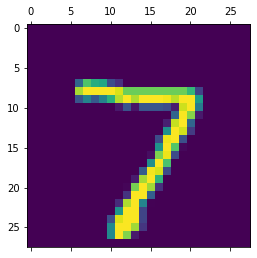

In [11]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [12]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


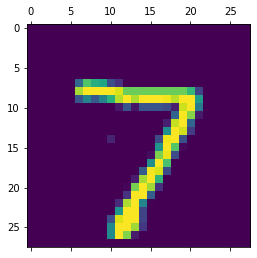

In [13]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [14]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 3


In [15]:
from art.estimators.classification import CatBoostARTClassifier

In [16]:
from catboost import CatBoostClassifier

In [17]:
def get_adversarial_examples(x_train, y_train):
    
    
    model = CatBoostClassifier(custom_loss=['Accuracy'], random_seed=42, logging_level='Silent')
    model.fit(x_train, y_train, cat_features=None, eval_set=(x_train, y_train))

    
    art_classifier = CatBoostARTClassifier(model=model, nb_features=x_train.shape[1])

    
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

   
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

In [18]:
model = CatBoostClassifier(custom_loss=['Accuracy'], random_seed=42, logging_level='Silent', depth=8, iterations=20)
model.fit(x_train, y_train, cat_features=None, eval_set=(x_train, y_train))

In [19]:
y_pred = model.predict_proba(x_train)
score = np.sum(y_train == np.argmax(y_pred, axis=1)) / y_train.shape[0]
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.9950


In [20]:
art_classifier = CatBoostARTClassifier(model=model, nb_features=x_train.shape[1])

In [21]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

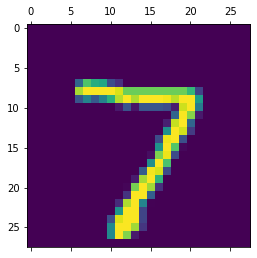

In [22]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [23]:
prediction = np.argmax(model.predict_proba(x_test[0:1, :]), axis=1)
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [24]:
x_test_adv = zoo.generate(x_test[0:1, :])

ZOO: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


In [25]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.0800


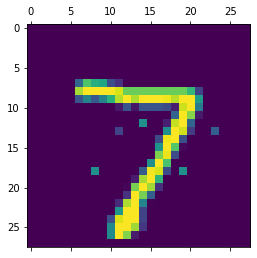

In [26]:
plt.matshow(x_test_adv.reshape((28, 28)))
plt.clim(0, 1)

In [27]:
prediction = np.argmax(model.predict_proba(x_test_adv), axis=1)
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 3


In [28]:
from sklearn.ensemble import BaggingClassifier

In [29]:
def get_adversarial_examples(x_train, y_train):
    
    
    model = BaggingClassifier()
    model.fit(X=x_train, y=y_train)

    
    art_classifier = SklearnClassifier(model=model)

   
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
   
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

In [30]:
model = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
                          bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                          n_jobs=None, random_state=None, verbose=0)

In [31]:
model.fit(X=x_train, y=y_train)

BaggingClassifier()

In [32]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


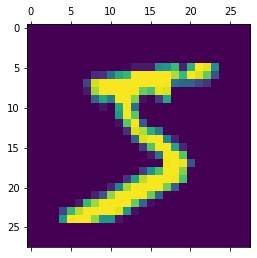

In [33]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [34]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [35]:
art_classifier = SklearnClassifier(model=model)

In [36]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

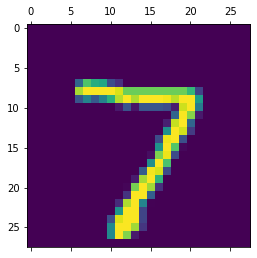

In [37]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [38]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [39]:
x_test_adv = zoo.generate(x_test[0:1, :])

ZOO: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


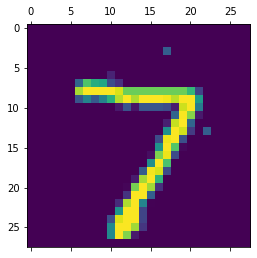

In [41]:
plt.matshow(x_test_adv.reshape((28, 28)))
plt.clim(0, 1)

In [42]:
prediction = model.predict(x_test_adv)[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 0


In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=50, min_impurity_decrease=0.0, 
                               min_impurity_split=None, class_weight=None) 

In [45]:
model.fit(X=x_train, y=y_train)

DecisionTreeClassifier(max_leaf_nodes=50)

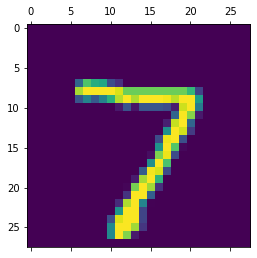

In [46]:
plt.matshow(x_test[0:1, :].reshape((28, 28)))
plt.clim(0, 1)

In [47]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [48]:
art_classifier = SklearnClassifier(model=model)

In [49]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [50]:
x_test_adv = zoo.generate(x_test[0:1, :])

ZOO: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [52]:
score = model.score(x_test, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.4650


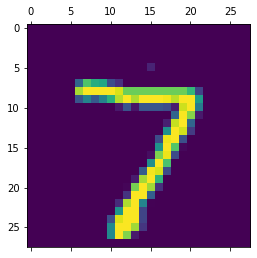

In [56]:
plt.matshow(x_test_adv.reshape((28, 28)))
plt.clim(0, 1)

In [57]:
prediction = model.predict(x_test_adv)[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 5


In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                           class_weight='balanced', random_state=None, solver='lbfgs', max_iter=100, 
                           multi_class='ovr', verbose=0, warm_start=False, n_jobs=None)

In [60]:
model.fit(X=x_train, y=y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr')

In [61]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7350


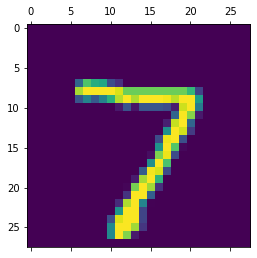

In [62]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [63]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [64]:
art_classifier = SklearnClassifier(model=model)

In [65]:
from art.attacks.evasion import ProjectedGradientDescent

In [66]:
pgd = ProjectedGradientDescent(estimator=art_classifier, norm=np.inf, eps=.3, eps_step=0.1, max_iter=20, 
                               targeted=False, num_random_init=0, batch_size=128)

In [67]:
x_test_adv = pgd.generate(x_test[0:1, :])

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 61.59it/s]


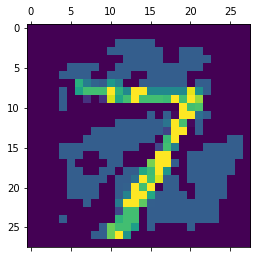

In [69]:
plt.matshow(x_test_adv.reshape((28, 28)))
plt.clim(0, 1)

In [70]:
prediction = model.predict(x_test_adv)[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 2


In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
model = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None)

In [73]:
model.fit(X=x_train, y=y_train)

RandomForestClassifier(n_estimators=10)

In [74]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.6100


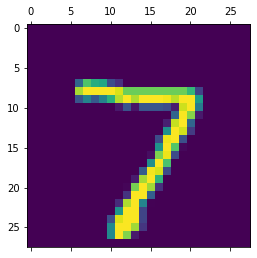

In [75]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [76]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [77]:
art_classifier = SklearnClassifier(model=model)
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [78]:
x_test_adv = zoo.generate(x_test)

ZOO: 100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


In [79]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2800


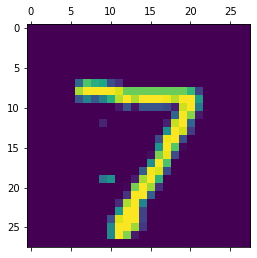

In [80]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [81]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 4
